In [13]:
import time
import re
import os
import math
import numpy as np
from matplotlib import pyplot as plt
import requests
import collections
import pickle
import copy, random
np.random.seed(1234)
import nltk as nl
nl.download('punkt')

from itertools import zip_longest

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Reshape, BatchNormalization, Dense, Dropout,       # General
    Embedding, LSTM, Dense, GRU,                              # RNN
    Conv2D, Conv2DTranspose, LeakyReLU, MaxPool2D, Flatten    # CNN
)
from tensorflow.keras.activations import elu, relu, softmax, sigmoid

print(tf.__version__)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2.2.0


In [14]:
#########################################################################################################
if False:
    class LearningConfig:
        def __init__(self, optimizer=tf.compat.v1.train.AdagradOptimizer, lr=0.001, norm_clip=100.0, batch_size=32,
                    lr_scheduler=True, max_no_improve=5, n_epochs=10,
                    trunc_norm_init_std=1e-4, is_test=False):
            self.batch_size = batch_size
            self.n_steps = 3500
            self.n_epochs = n_epochs
            self.lr = lr
            # self.optimizer = tf.train.AdamOptimizer
            self.optimizer = optimizer
            self.norm_clip = norm_clip

            self.lr_scheduler = lr_scheduler
            self.max_no_improve = max_no_improve

            self.trunc_norm_init_std = trunc_norm_init_std

            self.is_test = is_test


    class SyLMConfig:
        def __init__(self, vocab_size,
                    sentence_max_len, emb_size,
                    rnn_size, cell_type, keep_prob,
                    proj_size,
                    optimizer, lr, norm_clip, batch_size, n_epochs, lr_scheduler, max_no_improve,
                    restore_model,
                    is_test=False):
            """
            Language Model Configuration Class
            :param vocab_size:
            :param is_test:
            """

            self.is_test = is_test
            # General
            self.input_vocab_size = self.output_vocab_size = vocab_size
            self.sentence_max_len = sentence_max_len
            self.input_emb_size = self.output_emb_size = emb_size

            # Encoder
            self.encoder_rnn_size = rnn_size
            self.encoder_keep_prob = keep_prob if not is_test else 1
            self.cell_type = cell_type
            self.wrap_attention = False

            self.proj_size = proj_size

            # Learning
            self.learning = LearningConfig(optimizer, lr, norm_clip, batch_size, lr_scheduler, max_no_improve, n_epochs=n_epochs, is_test=is_test)
            self.restore_model = restore_model

        def set_params(self, dict):
            def _recursive_call(items, attr_id):
                items = list(items)
                attr_name = items[attr_id][0]
                attr_values = items[attr_id][1]
                for attr_value in attr_values:
                    setattr(self, attr_name, attr_value)
                    if attr_id == (len(items) - 1):  # base case[
                        yield self
                    else:
                        for i in _recursive_call(items, attr_id + 1):
                            yield i

            items = dict.items()
            for i in _recursive_call(items, 0):
                yield i

        def set_tied_params(self):
            self.output_emb_size = self.input_emb_size


    def setup_config(FLAGS):
        """
        :param FLAGS:
        :return:
        """

        config = SyLMConfig(vocab_size=FLAGS.vocab_size, sentence_max_len=FLAGS.sentence_max_len, emb_size=FLAGS.emb_size,
                rnn_size=FLAGS.enc_size, cell_type=FLAGS.rnn_cell_type, keep_prob=FLAGS.enc_keep_prob, proj_size=FLAGS.proj_size,
                optimizer=tf.train.AdamOptimizer, lr=FLAGS.lr, norm_clip=FLAGS.norm_clip, batch_size=FLAGS.batch_size, n_epochs=FLAGS.n_epochs,
                lr_scheduler=FLAGS.lr_scheduler, max_no_improve=FLAGS.max_no_improve, restore_model=FLAGS.restore_model, is_test=False)

        val_config = copy.deepcopy(config)
        val_config.encoder_keep_prob = 1.0
        val_config.is_test = True

        gen_config = copy.deepcopy(val_config)

        return config, val_config, gen_config



    def get_vowels(w):
        return [(c, i) for i, c in enumerate(w) if is_vowel(c)]

    def get_next_vowel_pos(word, start_pos=0):
        c = word[start_pos]
        count = start_pos
        while not is_vowel(c) or count == len(word):
            count += 1
            c = word[count]

        return count + 1


    def get_seq_hyphen_len(words):
        return sum([len(hyphenation(w)) for w in words])

    def hyp2word(hyphen, hyp_rev_vocabulary, special_tokens):
        word = ''
        for hyp in hyphen:
            if hyp not in special_tokens and hyp in hyp_rev_vocabulary:
                word += hyp_rev_vocabulary[hyp]
            elif hyp not in special_tokens:
                word += '<UNK>'

        return word


    def get_hyps(batch, hyp_rev_vocabulary, special_tokens):
        hyps = []
        for seq in batch:
            hyps.append('')
            for hyphen in seq:
                hyps[-1] += hyp2word(hyphen, hyp_rev_vocabulary, special_tokens) + ' '

        return hyps


    def print_hyps(batch, hyp_rev_vocabulary, special_tokens):
        for seq in batch:
            to_print = ''
            for hyphen in seq:
                to_print.join(hyp2word(hyphen, hyp_rev_vocabulary, special_tokens) + ' ')
            print(to_print)


    def print_paired_hyps(file, batch_y, batch_z, hyp_rev_vocabulary, special_tokens):
        hyps_y = get_hyps(batch_y, hyp_rev_vocabulary, special_tokens)
        hyps_z = get_hyps(batch_z, hyp_rev_vocabulary, special_tokens)

        for i in range(len(hyps_y)):
            print_and_write(file, 'Ground Truth: ' + hyps_y[i])
            print_and_write(file, 'Prediction: ' + hyps_z[i])


    def print_paired_output(file, batch_y, batch_z, rev_vocabulary, special_tokens, end_of_tokens=None):

        def output2string(batch, rev_vocabulary, special_tokens, end_of_tokens):
            output_strings = []
            for seq in batch:
                to_print = ''
                for token in seq:
                    if token in special_tokens:
                        to_print += ' '
                    elif end_of_tokens and token in end_of_tokens:
                        to_print += '\n'
                    elif token in rev_vocabulary:
                        to_print += rev_vocabulary[token]
                    else:
                        to_print += '<UNK>'
                output_strings.append(to_print)

            return output_strings

        hyps_y = output2string(batch_y, rev_vocabulary, special_tokens, end_of_tokens)
        hyps_z = output2string(batch_z, rev_vocabulary, special_tokens, end_of_tokens)

        for i in range(len(hyps_y)):
            print_and_write(file, "\n================================================")
            print_and_write(file, 'Ground Truth: ' + hyps_y[i] + "\n")
            print_and_write(file, 'Prediction: ' + hyps_z[i] + "\n")
            print_and_write(file, "================================================\n")


    def hyps2words(ids, sep, pad=-1, with_sep=False, omit_pad=True):
        """
        Splits the list of ids according to a separator.

        :param ids: a list of hyphen' ids
        :param sep: the separator token (INT value)
        :param pad (optional): id of the pad token (INT value)
        :param with_sep (optional): separators are omitted if True,
        otherwise they are kept
        :param omit_pad (optional): true or false to decide whether
        to omit pad token or not
        :return: a list of elements, where each element
        is a list of tokens composing a word
        """

        words = [[]]
        for id in ids:
            if id == sep:
                if with_sep:
                    words.append([sep])
                words.append([])
            elif id != pad or (id == pad and not omit_pad):
                words[-1].append(id)

        return words


    def hyps2word(hyps):
        """
        Converts a list of hyphens to a string.
        :param hyps: a list of strings (hyphens)
        :return: string of concatenated hyphens
        """

        return ''.join(hyps)


    def id2hyp(id, rev_dictionary):
        """
        Converts an id to its respective hyphen in rev_dictionary.
        :param id: an integer
        :param rev_dictionary: a Python dictionary
        with integer as keys and strings as values.
        :return: a string
        """
        return rev_dictionary[id] if id in rev_dictionary else '<UNK>'


    def hyp2id(hyp, dictionary):
        """
            Converts an hyphen to its respective id in dictionary.
            :param hyp: a string
            :param dictionary: a Python dictionary
            with string as keys and integers as values.
            :return: an integer
            """
        return dictionary[hyp] if hyp in dictionary else 0


    def ids2hyps(ids, rev_dictionary):
        """
        Maps a list of ids into a list of hyphens.
        :param ids: a list of ints
        :param rev_dictionary:  Python dictionary
        with string as keys and integers as values.
        :return: a list of strings (hyphens)
        """
        return [id2hyp(id, rev_dictionary) for id in ids]


    def is_word(hyps, word_dictionary):
        return hyps2word(hyps) in word_dictionary


    def hyps2verses(ids, eos, eot):
        """
        Split the list of hypens in different lists, separated
        by the sep token.
        :param ids: a list of hyphen' ids
        :param eos: the separator token (INT) (id corresponding to <EOS>)
        :return: a list of verses, each verse is a list of syllables
        """

        verses = [[]]
        for id in ids:
            if id == eot:
                break
            elif id == eos:
                verses.append([])
            else:
                verses[-1].append(id)

        if len(verses[-1]) < 1:
            verses = verses[:-1]

        return verses


    def hyphenize_list(l):
        """
        Given a corpus, the function tokenizes it by dividing words into syllables
        adding also a separator token between words.
        :param l: a list of sequences, each sequence is a list of words (strings).
        :return: a list of sequences, but each sequence is a list of syllables.
        """

        sentences = [seq_hyphentation(s) for s in l]
        sep_token = "<SEP>"
        hyphenated_sentences = []
        for s in sentences:
            hyphenated_sentences.append([])
            for w in s:
                hyphenated_sentences[-1].extend(w)
                hyphenated_sentences[-1].append(sep_token)
            hyphenated_sentences[-1] = hyphenated_sentences[-1][:-1]  # removes last sep_token

        return hyphenated_sentences

    def read_words_from_folder(data_path):
        try:
            nl.data.find('tokenizers/punkt')
        except LookupError:
            nl.download('punkt')
        list_files = [os.path.join(data_path, f)
                    for f in os.listdir(data_path)
                    if os.path.isfile(os.path.join(data_path, f))]
        words = []
        for filename in list_files:
            with open(filename, "r") as f:
                try:
                    st = f.read()
                except UnicodeDecodeError:
                    print("File "+filename+" decode error: SKIPPED")
                    continue
                st = st.translate(string.punctuation)
                data = nl.word_tokenize(st)
                del(st)
                words.extend(data)
        return words

    def build_dataset_of_tokens(tokens, vocabulary_size, special_tokens=[]):
        '''
        Given a list of tokens, it creates a dictionary mapping each token to a unique id.
        :param tokens: a list of strings.
        E.g. ["the", "cat", "is", ... ".", "the", "house" ,"is" ...].
        NB: Here you should put all your token instances of the corpus.
        :param vocabulary_size: The number of elements of your vocabulary. If there are more
        than 'vocabulary_size' elements on tokens, it considers only the 'vocabulary_size'
        most frequent ones.
        :param special_tokens: Optional. Useful to add special tokens in vocabulary. I
        f you don't have any, keep it empty.
        :return: data: the mapped tokens list;
        count: a dictionary containing the number of occurrences in 'tokens' for each
        element on your dictionary.
        dictionary: a python dictionary that associates a token with a unique integer identifier.
        reverse_dictionary: a python dictionary mapping a unique integer identifier to its token.
        E.g.
        dictionary:{"UNK": 0, "a": 1, "the": 2, ....}
        reverse_dictionary:{0:"UNK", 1:"a", 2:"the"}
        '''
        # counting occurrences of each token
        count = [['UNK', -1]]
        count.extend(collections.Counter(tokens).most_common(vocabulary_size - 1))  # takes only the most frequent ones
        dictionary = dict()
        for word, _ in count:
            dictionary[word] = len(dictionary)

        for token in special_tokens:
            dictionary[token[0]] = token[1]

        data = list()
        unk_count = 0
        for word in tokens:
            if word in dictionary:
                index = dictionary[word]
            else:
                index = 0  # dictionary['UNK']
                unk_count += 1
            data.append(index)
        count[0][1] = unk_count
        reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
        return data, count, dictionary, reverse_dictionary

    def save_dictionary_tsv(filepath, dictionary, count):
        keys, values = zip(*count)
        with open(filepath, 'w') as f:
            f.write('Word\tFrequency\n')
            for k, v in dictionary.items():
                if k in keys:
                    f.write(k + '\t' + str(values[keys.index(k)]) + '\n')
                else:
                    f.write(k + '\t' + '0' + '\n')


    def k_frequent(words_data, k):
        counter = collections.Counter(words_data)
        most = counter.most_common(k)
        res = [most[i][0] for i in range(len(most))]
        return res


    def toWord(chars):
        str =''
        for c in chars:
            if(c<2):
                continue
            elif(c==2):
                break
            str = str+chr(c)
        return str


    def grouper(iterable, n, fillvalue=None):
        args = [iter(iterable)] * n
        return zip_longest(*args, fillvalue=fillvalue)

    def get_cantica(filename, encoding=None):
        f_cantica = []
        count = 1
        with open(filename, "r", encoding=encoding) as f:
            for line in f:
                sentence = line.strip()
                tokenized_sentence = nl.word_tokenize(sentence)

                if len(tokenized_sentence) == 2:
                    # setting feature cantica for each canto
                    if count <= 34:
                        f_cantica.append([1, 0, 0])
                    elif count > 34 and count <= 67:
                        f_cantica.append([0, 1, 0])
                    else:
                        f_cantica.append([0, 0, 1])

                    count += 1

        return f_cantica

    def create_BAB_tercets(cantos):
        tercets = []
        for canto in cantos:
            for v,verse in enumerate(canto):
                if v%3 == 1:
                    tercets.append([])
                if v > 0: tercets[-1].append(verse)

            tercets = tercets[:-1] # removes the last malformed tercets (only 2 verses)

        return tercets


    def get_poetry(filename, encoding=None):
        # raw_data = read_words(filename=filename)

        raw_data, words = [], []
        # with open(filename, "r", encoding ='latin-1') as f:
        with open(filename, "r", encoding=encoding) as f:
            for line in f:
                sentence = line.strip()
                if len(sentence) > 1:
                    sentence = sentence.translate(string.punctuation)
                    tokenized_sentence = nl.word_tokenize(sentence)
                    tokenized_sentence = [w.lower() for w in tokenized_sentence if len(w)>0]
                    tokenized_sentence = [w for w in tokenized_sentence if "," not in w]
                    tokenized_sentence = [w for w in tokenized_sentence if "." not in w]
                    tokenized_sentence = [w for w in tokenized_sentence if ":" not in w]
                    tokenized_sentence = [w for w in tokenized_sentence if ";" not in w]
                    ts = []
                    [ts.extend(re.split("(\')", e)) for e in tokenized_sentence]
                    tokenized_sentence = [w for w in ts if len(w) > 0]

                    if len(tokenized_sentence) > 2:
                        raw_data.append(tokenized_sentence)
                        words.extend(tokenized_sentence)

        return raw_data, words

    def get_decameron(filename):
        raw_data, words = [], []
        with open(filename, "r", encoding='latin-1') as f:
            for line in f:
                raw_sentences = line.strip()
                if len(raw_sentences) > 1:
                    sentences = raw_sentences.translate(string.punctuation)
                    s_list = re.split("\.", sentences)
                    for s in s_list:
                        tokenized_sentences = nl.word_tokenize(s)
                        tokenized_sentences = [w.lower() for w in tokenized_sentences if len(w)>0]
                        tokenized_sentences = [w for w in tokenized_sentences if "," not in w]
                        # tokenized_sentences = [w for w in tokenized_sentences if "." not in w]
                        tokenized_sentences = [w for w in tokenized_sentences if ":" not in w]
                        ts = []
                        [ts.extend(re.split("(\')", e)) for e in tokenized_sentences]
                        tokenized_sentences = [w for w in ts if len(w) > 0]

                        if len(tokenized_sentences) > 1 and len(tokenized_sentences) < 30:
                            raw_data.append(tokenized_sentences)
                            words.extend(tokenized_sentences)

        return raw_data, words


    def build_dataset_from_dict(raw_data, dictionary, config, shuffle=True):
        '''
        Converts all the tokens in raw_data by mapping each token with its corresponding
        value in the dictionary. In case of token not in the dictionary, they are assigned to
        a specific id. Each sequence is padded up to the sentence_max_len setup in the config.

        :param raw_data: list of sequences, each sequences is a list of tokens (strings).
        :param dictionary: a python dictionary having as keys strings
        and int tokens as values.
        :param config: config object from class Config.
        :param shuffle: Optional. If True data are shuffled.
        :return: A list of sequences where each token in each sequence is an int id.
        '''
        dataset = []
        for sentence in raw_data:
            sentence_ids = [config._GO]
            sentence_ids.extend([dictionary[w] if w in dictionary else dictionary["UNK"] for w in sentence])
            sentence_ids.append(config._EOS)
            sentence_ids = pad_list(sentence_ids, config._PAD, config.sentence_max_len)

            dataset.append(sentence_ids)

        if shuffle:
            return random.sample(dataset, len(dataset))
        else:
            return dataset


    def build_stanzas_dataset_from_dict(raw_data, dictionary, config, shuffle=True):
        dataset = []
        for stanza in raw_data:
            stanza_ids = [config._GO]
            for sentence in stanza:
                sentence_ids = [dictionary[w] if w in dictionary else dictionary["UNK"] for w in sentence]
                sentence_ids.append(config._EOS)
                stanza_ids.extend(sentence_ids)
            # stanza_ids.append(config._EOT)
            stanza_ids[-1] = config._EOT
            stanza_ids = pad_list(stanza_ids, config._PAD, config.sentence_max_len)

            dataset.append(stanza_ids)

        if shuffle:
            return random.sample(dataset, len(dataset))
        else:
            return dataset


    def build_stanzas_dataset_from_subword_dict(raw_data, dictionary, config, shuffle=True):
        dataset = []
        for stanza in raw_data:
            stanza_ids = [pad_list([config._GO], config._PAD, config.word_max_len)]
            for sentence in stanza:
                for word in sentence:
                    hyp_ids = [dictionary[hyp] if hyp in dictionary else dictionary["UNK"] for hyp in word]
                    hyp_ids.append(config._EOW)
                    hyp_ids = pad_list(hyp_ids, config._PAD, config.word_max_len)
                    stanza_ids.extend([hyp_ids])

                stanza_ids.append(pad_list([config._EOS], config._PAD, config.word_max_len))
            # stanza_ids.append(config._EOT)
            stanza_ids[-1] = pad_list([config._EOT], config._PAD, config.word_max_len)
            stanza_ids = pad_list(stanza_ids, [config._PAD] * config.word_max_len, config.sentence_max_len)

            dataset.append(stanza_ids)

        if shuffle:
            return random.sample(dataset, len(dataset))
        else:
            return dataset


    def build_stanzas_dataset_from_chars(raw_data, config):
        dataset = []
        for stanza in raw_data:
            stanza_ids = []
            for sentence in stanza:
                sentence_ids = [to_chars([w], config.word_max_len)[0] for w in sentence]
                sentence_ids.append(to_chars(["<EOS>"], config.word_max_len)[0])
                stanza_ids.extend(sentence_ids)
            stanza_ids.append(to_chars(["<EOT>"], config.word_max_len)[0])
            stanza_ids = pad_list(stanza_ids, to_chars(["<pad>"], config.word_max_len)[0], config.sentence_max_len)

            dataset.append(stanza_ids)
        return random.sample(dataset, len(dataset))

    def create_lm_target(x, config):
        return [e[1:] + [config._PAD] for e in x]


    def create_hyp_lm_target(x, config):
        return [e[1:] + [[config._PAD] * config.word_max_len] for e in x]


    def batches(x, y, batch_size=128):

        # Shuffle sentences
        sentences_ids = random.sample(range(len(x)), len(x))

        # Generator for batch
        batch_x, batch_y = [], []
        if batch_size is None:
            batch_size = len(x)
        for id in sentences_ids:
            batch_x.append(x[id])
            batch_y.append(y[id])
            if len(batch_x) % batch_size == 0:
                yield batch_x, batch_y
                batch_x, batch_y = [], []


    def _batches(iterable, batch_size=128):

        # Shuffle sentences
        x = list(zip(*iterable))
        sentences_ids = random.sample(range(len(x)), len(x))

        # Generator for batch
        batch, batch_y = [], []
        if batch_size is None:
            batch_size = len(x)
        for id in sentences_ids:
            batch.append(x[id])
            if len(batch) % batch_size == 0:
                yield batch
                batch = []


    def batches3(chars, x, y, batch_size=128):

        # Shuffle sentences
        sentences_ids = random.sample(range(len(x)), len(x))

        # Generator for batch
        batch_chars, batch_x, batch_y = [], [], []
        if batch_size is None:
            batch_size = len(x)
        for id in sentences_ids:
            batch_chars.append(chars[id])
            batch_x.append(x[id])
            batch_y.append(y[id])
            if len(batch_x) % batch_size == 0:
                yield batch_chars, batch_x, batch_y
                batch_chars, batch_x, batch_y = [], [], []


    def are_in_rhyme(w1, w2):

        def find_termination(w):
            v_count = 0
            for i in range(len(w)-1, -1, -1):
                if is_vowel(w[i]):
                    v_count += 1
                    if v_count == 2 and i < len(w)-2:
                        # se è la seconda vocale che trovo, è una vocale e non è nel penultimo carattere
                        return w[i:]
                    elif v_count == 3:
                        # se è la terza vocale che trovo
                        return w[i:]

        t1 = find_termination(w1)
        t2 = find_termination(w2)
        if t1 and t2 and t1 == t2 and len(t1) > 1 and len(t2) > 1:
            return True

        return False

    def general_batches(iterables, full_size, batch_size=128):
        if batch_size == None:
            batch_size = full_size

        batch = []
        for i in range(len(iterables)):
            batch.append([])

        for id in range(full_size):
            for i,it in enumerate(iterables):
                batch[i].append(it[id])
            if len(batch[0]) % batch_size == 0:
                yield batch
                batch = []
                for i in range(len(iterables)):
                    batch.append([])

    def get_sonnets(verses, N=14):
        sonnets, words = [], []
        for v, verse in enumerate(verses):
            if v % N == 0:
                sonnets.append([])

            tokenized_sentence = [w.lower().strip() for w in nl.word_tokenize(verse) if len(w) > 0]
            tokenized_sentence = [w for w in tokenized_sentence if "," not in w]
            tokenized_sentence = [w for w in tokenized_sentence if "." not in w]
            tokenized_sentence = [w for w in tokenized_sentence if ":" not in w]
            tokenized_sentence = [w for w in tokenized_sentence if ";" not in w]
            tokenized_sentence = [w for w in tokenized_sentence if "«" not in w]
            tokenized_sentence = [w for w in tokenized_sentence if "»" not in w]
            tokenized_sentence = [w for w in tokenized_sentence if "‘" not in w]
            tokenized_sentence = [w for w in tokenized_sentence if "‘‘" not in w]
            tokenized_sentence = [w for w in tokenized_sentence if "(" not in w]
            tokenized_sentence = [w for w in tokenized_sentence if ")" not in w]
            ts = []
            [ts.extend(re.split("(\')", e)) for e in tokenized_sentence]
            tokenized_sentence = [w for w in ts if len(w) > 0]
            sonnets[-1].append(tokenized_sentence)
            words.extend(tokenized_sentence)

        return sonnets, words

    def load_paisa_data(filename, n_docs=15000):
        with open(filename, 'r', encoding="utf8") as f:
            it_data = []
            c = 0
            for line in f:
                if line[0] not in ['#', '<'] and len(line) > 150:
                    line = re.sub('\d+', '0', line)
                    line = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'url', line)
                    line = re.sub(',', ' , ', line)
                    line = re.sub(';', ' ; ', line)
                    line = re.sub(':', ' : ', line)
                    line = re.sub('\(', ' ( ', line)
                    line = re.sub('\)', ' ) ', line)
                    line = re.sub("\'", " \' ", line)
                    line = line.lower()
                    it_data.append(line)
                    if c >= n_docs:
                        break
                    c += 1

            return it_data


    def build_dataset_with_context(raw_data, dictionary, config, pad_len):
        dataset = []
        for sentence in raw_data:
            stanza_ids = [config._GO]
            sentence_ids = [dictionary[w] if w in dictionary else dictionary["UNK"] for w in sentence]
            sentence_ids.append(config._EOS)
            stanza_ids.extend(sentence_ids)
            stanza_ids = pad_list(stanza_ids, config._PAD, pad_len)

            dataset.append(stanza_ids)

        return dataset

    def split_in_ngrams(x, n=3, pad_token='_'):
        '''
        Arguments:
        'x' a string of text, e.g. a word a sentence.
        'pad_token' the token to add to unfinished trigrams.

        Returns:
        a list containing 'x' split in trigrams.'''

        trigrams = []
        for i, ch in enumerate(x):
            if i % n == 0:
                trigrams.append('')

            trigrams[-1] += ch

        for p in range(3 - len(trigrams[-1])):
            trigrams[-1] += pad_token

        return trigrams


    def get_ngrams(l, n=3, pad_token='_'):
        '''
        Arguments:
        'l' an input list of words.
        'pad_token' the token to add to unfinished trigrams.

        Returns:
        a list of the trigrams of 'l'.'''
        trigrams = []
        for w in l:
            t = split_in_ngrams(w, n, pad_token)
            trigrams.extend(t)

        return trigrams


    def get_ngrams_from_tercets(tercets, n=3, pad_token='_'):
        '''
        Arguments:
        'tercets' a list of tercets.
        'pad_token' the token to add to unfinished trigrams.

        Returns:
        'tr_tercets' a list of tercets splitted in trigrams
        'trigrams' a list of all the trigrams'''
        tr_tercets, trigrams = [], []
        for tercet in tercets:
            tr_tercets.append([])
            for verse in tercet:
                # t = split_in_ngrams(verse, pad_token) # CHANGE IN get_ngrams IF tercets are not raw
                t = get_ngrams(verse, n, pad_token)
                tr_tercets[-1].append(t)
                trigrams.extend(t)

        return tr_tercets, trigrams


    def get_ngrams_from_canzoniere(verses, n=3, pad_token='_'):
        '''
        Arguments:
        'verses' a list of verses.
        'pad_token' the token to add to unfinished trigrams.

        Returns:
        'tr_tercets' a list of tercets splitted in trigrams
        'trigrams' a list of all the trigrams'''
        tr_verses, trigrams = [], []
        for verse in verses:
            # t = split_in_ngrams(verse, pad_token) # CHANGE IN get_ngrams IF tercets are not raw
            t = get_ngrams(verse, n, pad_token)
            tr_verses.append(t)
            trigrams.extend(t)

        return tr_verses, trigrams





    def get_quatrains(shake_sonnets):
        quatrains, words = [],[]
        for sonnet in shake_sonnets:
            quatrains.extend([sonnet[:4],sonnet[4:8], sonnet[:8:-2]])

        return quatrains




    def get_context_dataset(sequences):
        x_seq = []
        for seq in sequences:
            for i, c_verse in enumerate(seq):
                context = []
                [context.extend(v) for v in seq[:i]]
                x_seq.append((context, c_verse))

        return x_seq


    def load_textual_corpus(filename, max_n_lines=-1):
        '''
        General function to load a textual file from corpus. A list of sentences
        is given as return, data is also cleaned up to remove urls and numbers. Sentences are
        split according to the dot '.' .
        :param filename: the name of the textual file to load.
        :param max_n_lines: Maximum number of lines to load from the file. Useful for huge corpora.
        Set to -1 (default), to get all the lines.
        :return: A list of sentences, where each sentence is a list of words.
        '''

        with open(filename, 'r', encoding="utf8", errors='ignore') as f:
            data = []
            c = 0
            for line in f:
                line = re.sub('\d+', '0', line)
                line = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'url', line)
                line = re.sub(',', ' , ', line)
                line = re.sub(';', ' ; ', line)
                line = re.sub(':', ' : ', line)
                line = re.sub('\(', ' ( ', line)
                line = re.sub('\)', ' ) ', line)
                line = re.sub("\'", " \' ", line)
                line = line.lower()
                data.extend([s.strip().split() for s in line.split(".") if len(s) > 2])

                if max_n_lines > 0 and c >= max_n_lines:
                    break
                c += 1

            return data


    def load_poetry_corpus(filename, scheme_n=3):
        with open(filename, 'r', encoding="utf8", errors='ignore') as f:
            data = []
            j = 0
            for line in f:
                if len(line) > 1:
                    line = re.sub(',', ' , ', line)
                    line = re.sub(';', ' ; ', line)
                    line = re.sub(':', ' : ', line)
                    line = re.sub('\(', ' ( ', line)
                    line = re.sub('\)', ' ) ', line)
                    line = re.sub("\'", " \' ", line)
                    line = line.lower()
                    tokenized_line = nl.word_tokenize(line)
                    # tokenized_line = tokenized_line.split()
                    tokenized_line = [w for w in tokenized_line if "," not in w]
                    tokenized_line = [w for w in tokenized_line if "." not in w]
                    tokenized_line = [w for w in tokenized_line if ":" not in w]
                    tokenized_line = [w for w in tokenized_line if ";" not in w]
                    tokenized_line = [w for w in tokenized_line if "!" not in w]
                    tokenized_line = [w for w in tokenized_line if "?" not in w]
                    tokenized_line = [w for w in tokenized_line if "«" not in w]
                    tokenized_line = [w for w in tokenized_line if "»" not in w]

                    if j % scheme_n == 0:
                        data.append([])
                    data[-1].append(tokenized_line)

                    j += 1

            return data


    def load_dantes_poetry(filenames, stanza_size=3):
        '''

        :param filenames: A list of filenames containing raw textual Dante's data.
        :param stanza_size: The number of verses to group together.
        :return: a list of stanzas, each stanza is a list of verses
        '''

        poetries = []
        for filename in filenames:
            poetries.extend(load_poetry_corpus(filename, stanza_size))

        return poetries


    def load_dantes_prose(filenames, max_n_lines=-1):
        '''
        Function to retrieve Dante's prose.
        :param filenames: A list of filenames containing raw textual Dante's data.
        :param max_n_lines: Maximum number of lines to load from the files.
        Default value -1, indicates no limit.
        :return: A list of sentences.
        '''

        prose = []
        for filename in filenames:
            sentences = load_textual_corpus(filename, max_n_lines)
            prose.extend(sentences)

        return prose

    

    _PAD = 0
    _GO = 1
    _EOW = 2
    _UNK = 3
    def to_chars(words, word_max_size):
        _PAD = 0
        _GO = 1
        _EOW = 2
        _UNK = 3
        chars = ['_PAD', '_GO', '_EOW', '_UNK', ' ', '!', '"', '#', '$', '%', '&', '\'', '(', ')',
                '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
                'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y',
                'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i',
                'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
                'z', '{', '|', '}', 'ì', 'ò', 'ù', 'è', 'é', 'à']
        char_dict = {}
        for char in chars:
            char_dict[char] = len(char_dict)
        char_words = np.ndarray(shape=[len(words), word_max_size], dtype=np.int32)
        for i in range(len(words)):
            if words[i]=="<pad>":
                char_words[i][:] = _PAD
                continue
            char_words[i][0]=_GO
            for j in range(1,word_max_size):
                if j < len(words[i])+1:
                    if words[i][j-1] in char_dict:
                        char_words[i][j] = char_dict[words[i][j-1]]
                    else:
                        char_words[i][j] = _UNK
                elif j == len(words[i])+1:
                    char_words[i][j] = _EOW
                else:
                    char_words[i][j] = _PAD
            if char_words[i][word_max_size-1] != _PAD:
                char_words[i][word_max_size-1] = _EOW
        return char_words

    '''
    Read a file (filename) and return the textual content of the file in a vector of words
    '''

    def read_words(filename, max_len=None):
        try:
            nl.data.find('tokenizers/punkt')
        except LookupError:
            nl.download('punkt')
        with open(filename, "r") as f:
            st = f.read()
            st = st.translate(string.punctuation)
            data = nl.word_tokenize(st)
            del(st)
            if max_len:
                return data[:max_len]
            return data
############################################################################
def get_hyp_lm_tercets(tercets):
    new_tercets = []
    for tercet in tercets:
        new_tercets.append([])
        for verse in tercet:
            new_tercets[-1].append([])
            for hyp_w in verse:
                new_tercets[-1][-1].extend(hyp_w)
                new_tercets[-1][-1].append('<SEP>')
            new_tercets[-1][-1] = new_tercets[-1][-1][:-1]

    return new_tercets

def is_vowel(c):
    return c in 'aeiouAEIOUàìíèéùúüòï'

def unsplittable_cons():
    u_cons = []
    for c1 in ('b', 'c', 'd', 'f', 'g', 'p', 't', 'v'):
        for c2 in ('l', 'r'):
            u_cons.append(c1 + c2)

    others = ['gn', 'gh', 'ch']
    u_cons.extend(others)
    return u_cons


def are_cons_to_split(c1, c2):
    to_split = ('cq', 'cn', 'lm', 'rc', 'bd', 'mb', 'mn', 'ld', 'ng', 'nd', 'tm', 'nv', 'nc', 'ft', 'nf', 'gm', 'fm', 'rv', 'fp')
    return (c1 + c2) in to_split or (not is_vowel(c1) and (c1 == c2)) or ((c1 + c2) not in unsplittable_cons()) and (
        (not is_vowel(c1)) and (not is_vowel(c2)) and c1 != 's')


def is_diphthong(c1, c2):
    return (c1 + c2) in ('ia', 'ie', 'io', 'iu', 'ua', 'ue', 'uo', 'ui', 'ai', 'ei', 'oi', 'ui', 'au', 'eu', 'ïe', 'iú', 'iù')


def is_triphthong(c1, c2, c3):
    return (c1 + c2 + c3) in ('iai', 'iei', 'uoi', 'uai', 'uei', 'iuo')


def is_toned_vowel(c):
    return c in 'àìèéùòï'

def has_vowels(sy):
    for c in sy:
        if is_vowel(c):
            return True
    return False


def hyphenation(word):
    """
    Split word in syllables
    :param word: input string
    :return: a list containing syllables of the word
    """
    if not word or word == '':
        return []
    # elif len(word) == 3 and (is_vowel(word[1]) and is_vowel(word[2]) and not is_toned_vowel(word[2]) and (
    #     not is_diphthong(word[1], word[2]) or (word[1] == 'i'))):
    elif len(word) == 3 and (is_vowel(word[1]) and is_vowel(word[2]) and not is_toned_vowel(word[2]) and (
        not is_diphthong(word[1], word[2]))):
        return [word[:2]] + [word[2]]
    elif len(word) == 3 and is_vowel(word[0]) and not is_vowel(word[1]) and is_vowel(word[2]):
        return [word[:2]] + [word[2]]
    elif len(word) == 3:
        return [word]

    syllables = []
    is_done = False
    count = 0
    while not is_done and count <= len(word) - 1:
        syllables.append('')
        c = word[count]
        while not is_vowel(c) and count < len(word) - 1:
            syllables[-1] = syllables[-1] + c
            count += 1
            c = word[count]

        syllables[-1] = syllables[-1] + word[count]

        if count == len(word) - 1:
            is_done = True
        else:
            count += 1

            if count < len(word) and not is_vowel(word[count]):
                if count == len(word) - 1:
                    syllables[-1] += word[count]
                    count += 1
                elif count + 1 < len(word) and are_cons_to_split(word[count], word[count + 1]):
                    syllables[-1] += word[count]
                    count += 1
                elif count + 2 < len(word) and not is_vowel(word[count + 1]) and not is_vowel(word[count + 2]) and word[
                    count] != 's':
                    syllables[-1] += word[count]
                    count += 1
            elif count < len(word):
                if count + 1 < len(word) and is_triphthong(word[count - 1], word[count], word[count + 1]):
                    syllables[-1] += word[count] + word[count + 1]
                    count += 2
                elif is_diphthong(word[count - 1], word[count]):
                    syllables[-1] += word[count]
                    count += 1

                if count + 1 < len(word) and are_cons_to_split(word[count], word[count + 1]):
                    syllables[-1] += word[count]
                    count += 1

            else:
                is_done = True

    if not has_vowels(syllables[-1]) and len(syllables) > 1:
        syllables[-2] = syllables[-2] + syllables[-1]
        syllables = syllables[:-1]

    return syllables



def get_dc_hyphenation(canti):
    hyp_canti, hyp_tokens = [], []
    for canto in canti:
        hyp_canti.append([])
        for verso in canto:
            syllables = seq_hyphentation(verso)
            hyp_canti[-1].append(syllables)
            for syllable in syllables:
                hyp_tokens.extend(syllable)

    return hyp_canti, hyp_tokens


def seq_hyphentation(words):
    """
    Converts words in a list of strings into lists of syllables
    :param words: a list of words (strings)
    :return: a list of lists containing word syllables
    """
    return [hyphenation(w) for w in words]


def get_dc_cantos(filename, encoding=None):
    # raw_data = read_words(filename=filename)
    cantos, words, raw = [], [], []
    with open(filename, "r", encoding=encoding) as f:
        for line in f:
            sentence = line.strip()
            sentence = str.replace(sentence, "\.", " \. ")
            sentence = str.replace(sentence, "[", '')
            sentence = str.replace(sentence, "]", '')
            sentence = str.replace(sentence, "-", '')
            sentence = str.replace(sentence, ";", " ; ")
            sentence = str.replace(sentence, ",", " , ")
            # sentence = str.replace(sentence, " \'", '')
            sentence = str.replace(sentence, "\'", ' \' ')
            if len(sentence) > 1:
                # sentence = sentence.translate(string.punctuation)
                tokenized_sentence = nl.word_tokenize(sentence)
                # tokenized_sentence = sentence.split()
                tokenized_sentence = [w.lower() for w in tokenized_sentence if len(w) > 0]
                tokenized_sentence = [w for w in tokenized_sentence if "," not in w]
                tokenized_sentence = [w for w in tokenized_sentence if "." not in w]
                tokenized_sentence = [w for w in tokenized_sentence if ":" not in w]
                tokenized_sentence = [w for w in tokenized_sentence if ";" not in w]
                tokenized_sentence = [w for w in tokenized_sentence if "«" not in w]
                tokenized_sentence = [w for w in tokenized_sentence if "»" not in w]
                # ts = []
                ts = tokenized_sentence
                # [ts.extend(re.split("(\')", e)) for e in tokenized_sentence]
                tokenized_sentence = [w for w in ts if len(w) > 0]

                if len(tokenized_sentence) == 2:
                    cantos.append([])
                    raw.append([])
                elif len(tokenized_sentence) > 2:
                    raw[-1].append(sentence)
                    cantos[-1].append(tokenized_sentence)
                    words.extend(tokenized_sentence)

    return cantos, words, raw


def create_tercets(cantos):
    tercets = []
    for i,canto in enumerate(cantos):
        for v,verse in enumerate(canto):
            if v%3 == 0:
                tercets.append([])

            tercets[-1].append(verse)
        tercets = tercets[:-1]  # removes the last malformed tercets (only 2 verses)

    return tercets

def pad_list(l, pad_token, max_l_size, keep_lasts=False, pad_right=True):
    """
    Adds a padding token to a list
    inputs:
    :param l: input list to pad.
    :param pad_token: value to add as padding.
    :param max_l_size: length of the new padded list to return,
    it truncates lists longer that 'max_l_size' without adding
    padding values.
    :param keep_lasts: If True, preserves the max_l_size last elements
    of a sequence (by keeping the same order).  E.g.:
    if keep_lasts is True and max_l_size=3 [1,2,3,4] becomes [2,3,4].


    :return: the list padded or truncated.
    """
    to_pad = []
    max_l = min(max_l_size, len(l))  # maximum len
    l_init = len(l) - max_l if len(l) > max_l and keep_lasts else 0  # initial position where to sample from the list
    l_end = len(l) if len(l) > max_l and keep_lasts else max_l
    for i in range(l_init, l_end):
        to_pad.append(l[i])

    # for j in range(len(l), max_l_size):
    #     to_pad.append(pad_token)
    pad_tokens = [pad_token] * (max_l_size-len(l))
    padded_l = to_pad + pad_tokens if pad_right else pad_tokens + to_pad

    return padded_l


def save_data(data, file):
    with open(file, 'wb') as output:
        pickle.dump(data, output, pickle.HIGHEST_PROTOCOL)

def load_data(file):
    with open(file, 'rb') as obj:
        return pickle.load(obj)

def print_and_write(file, s):
    print(s)
    file.write(s)


class Vocabulary(object):
    def __init__(self, vocab_size=None):
        self.dictionary = dict()
        self.rev_dictionary = dict()
        self.count = []
        self.special_tokens = []
        self.vocab_size = vocab_size

    def build_vocabulary_from_counts(self, count, special_tokens=[]):
        """
        Sets all the attributes of the Vocabulary object.
        :param count: a list of lists as follows: [['token', number_of_occurrences],...]
        :param special_tokens: a list of strings. E.g. ['<EOS>', '<PAD>',...]
        :return: None
        """

        dictionary = dict()
        for word, _ in count:
            dictionary[word] = len(dictionary)

        # adding eventual special tokens to the dictionary (e.g. <EOS>,<PAD> etc..)
        d = len(dictionary)
        for i, token in enumerate(special_tokens):
            dictionary[token] = d + i

        self.count = count
        self.dictionary = dictionary
        self.rev_dictionary = dict(zip(self.dictionary.values(), self.dictionary.keys()))
        self.special_tokens = special_tokens
        self.vocab_size = len(dictionary)

    def build_vocabulary_from_tokens(self, tokens, vocabulary_size=None, special_tokens=[]):
        """
        Given a list of tokens, it sets the Vocabulary object attributes by constructing
        a dictionary mapping each token to a unique id.
        :param tokens: a list of strings.
         E.g. ["the", "cat", "is", ... ".", "the", "house" ,"is" ...].
         NB: Here you should put all your token instances of the corpus.
        :param vocabulary_size: The number of elements of your vocabulary. If there are more
        than 'vocabulary_size' elements on tokens, it considers only the 'vocabulary_size'
        most frequent ones.
        :param special_tokens: Optional. A list of strings. Useful to add special tokens in vocabulary.
        If you don't have any, keep it empty.
        :return: None
        """

        vocabulary_size = vocabulary_size if vocabulary_size is not None else self.vocab_size
        vocabulary_size = vocabulary_size - (len(special_tokens) + 1) if vocabulary_size else None
        # counts occurrences of each token
        count = [['<UNK>', -1]]
        count.extend(collections.Counter(tokens).most_common(vocabulary_size))  # takes only the most frequent ones, if size is None takes them all
        self.build_vocabulary_from_counts(count, special_tokens)  # actually build the vocabulary
        self._set_unk_count(tokens)  # set the number of OOV instances

    @staticmethod
    def merge_vocabulary(vocab0, vocab1, vocabulary_size=-1):
        """
        Merge two Vocabulary objects into a new one.
        :param vocab0: first Vocabulary object
        :param vocab1: second Vocabulary object
        :param vocabulary_size: parameter to decide the merged vocabulary size.
        With default value -1, all the words of both vocabularies are preserved.
        When set to 0, the size of the vocabulary is set to the size of vocab0,
        when set to 1 it is kept the size of vocab1.
        :return: a new vocabulary
        """
        # get size of the new vocabulary
        vocab_size = vocab0.vocab_size + vocab1.vocab_size if vocabulary_size == -1 else vocabulary_size
        merged_special_tokens = list(set(vocab0.special_tokens) | set(vocab1.special_tokens))

        # merge the counts from the two vocabularies and then selects the most_common tokens
        merged_counts = collections.Counter(dict(vocab0.count)) + collections.Counter(dict(vocab1.count))
        merged_counts = merged_counts.most_common(vocab_size)
        count = [['<UNK>', -1]]
        count.extend(merged_counts)

        # create the new vocabulary
        merged_vocab = Vocabulary(vocab_size)
        merged_vocab.build_vocabulary_from_counts(count, merged_special_tokens)
        return merged_vocab

    @staticmethod
    def merge_vocabularies(vocab_list, vocab_size=None):
        """
        Join a list of vocabularies into a new one.
        :param vocab_list: a list of Vocabulary objects
        :param vocab_size: the maximum size of the merged vocabulary.
        :return: a vocabulary merging them all.
        """
        vocab_size = vocab_size if vocab_size else sum([v.vocab_size for v in vocab_list])
        merged_vocab = Vocabulary(vocab_size)
        for voc in vocab_list:
            merged_vocab = Vocabulary.merge_vocabulary(merged_vocab, voc, vocab_size)
        return merged_vocab

    def string2id(self, dataset):
        """
        Converts a dataset of strings into a dataset of ids according to the object dictionary.
        :param dataset: any string-based dataset with any nested lists.
        :return: a new dataset, with the same shape of dataset, where each string is mapped into its
        corresponding id associated in the dictionary (0 for unknown tokens).
        """

        def _recursive_call(items):
            new_items = []
            for item in items:
                if isinstance(item, str) or isinstance(item, int) or isinstance(item, float):
                    new_items.append(self.word2id(item))
                else:
                    new_items.append(_recursive_call(item))
            return new_items

        return _recursive_call(dataset)

    def id2string(self, dataset):
        """
        Converts a dataset of integer ids into a dataset of string according to the reverse dictionary.
        :param dataset: any int-based dataset with any nested lists. Allowed types are int, np.int32, np.int64.
        :return: a new dataset, with the same shape of dataset, where each token is mapped into its
        corresponding string associated in the reverse dictionary.
        """
        def _recursive_call(items):
            new_items = []
            for item in items:
                if isinstance(item, int) or isinstance(item, np.int) or isinstance(item, np.int32) or isinstance(item, np.int64):
                    new_items.append(self.id2word(item))
                else:
                    new_items.append(_recursive_call(item))
            return new_items

        return _recursive_call(dataset)

    def word2id(self, item):
        """
        Maps a string token to its corresponding id.
        :param item: a string.
        :return: If the token belongs to the vocabulary, it returns an integer id > 0, otherwise
        it returns the value associated to the unknown symbol, that is typically 0.
        """
        return self.dictionary[item] if item in self.dictionary else self.dictionary['<UNK>']

    def id2word(self, token_id):
        """
        Maps an integer token to its corresponding string.
        :param token_id: an integer.
        :return: If the id belongs to the vocabulary, it returns the string
        associated to it, otherwise it returns the string associated
        to the unknown symbol, that is '<UNK>'.
        """

        return self.rev_dictionary[token_id] if token_id in self.rev_dictionary else self.rev_dictionary[self.dictionary['<UNK>']]

    def get_unk_count(self):
        return self.count[0][1]

    def _set_unk_count(self, tokens):
        """
        Sets the number of OOV instances in the tokens provided
        :param tokens: a list of tokens
        :return: None
        """
        data = list()
        unk_count = 0
        for word in tokens:
            if word in self.dictionary:
                index = self.dictionary[word]
            else:
                index = 0  # dictionary['<UNK>']
                unk_count += 1
            data.append(index)
        self.count[0][1] = unk_count

    def add_element(self, name, is_special_token=False):
        if name not in self.dictionary:
            self.vocab_size += 1
            self.dictionary[name] = self.vocab_size
            self.rev_dictionary[self.vocab_size] = name

            if is_special_token:
                self.special_tokens = list(self.special_tokens)
                self.special_tokens.append(name)

            self.count.append([name, 1])

    def set_vocabulary(self, dictionary, rev_dictionary, special_tokens, vocab_size):
        self.dictionary = dictionary,
        self.rev_dictionary = rev_dictionary
        self.special_tokens = special_tokens
        self.vocab_size = vocab_size

    @staticmethod
    def load_vocabulary(filename):
        return load_data(filename)

    def save_vocabulary(self, filename):
        save_data(self, filename)







class SyLMDataset(object):
    def __init__(self, config, sy_vocab=None):
        self.config = config
        self.vocabulary = sy_vocab

        self.raw_train_x = []
        self.raw_val_x = []
        self.raw_test_x = []
        self.raw_x = []

        self.train_x, self.train_y = [], []
        self.val_x, self.val_y = [], []
        self.test_x, self.test_y = [], []
        self.x, self.y = [], []

    def initialize(self, sess):
        pass

    def load(self, sources):
        """
        Extract raw texts form sources and gather them all together.
        :param sources: a string or an iterable of strings containing the file(s)
        to process in order to build the dataset.
        :return: a list of raw strings.
        """
        return NotImplementedError

    def build(self, sources, split_size=0.8):
        """
        :param sources: a string or an iterable of strings containing the file(s)
        to process in order to build the dataset.
        :param split_size: the size to split the dataset, set >=1.0 to not split.
        """

        raw_x = self.load(sources)
        # raw_x = self.tokenize([self.preprocess(ex) for ex in raw_x])  # fixme
        # splitting data
        self.raw_x = raw_x
        if split_size < 1.0:
            self.raw_train_x, self.raw_test_x = self.split(self.raw_x, train_size=split_size)
            self.raw_train_x, self.raw_val_x = self.split(self.raw_train_x, train_size=split_size)
        else:
            self.raw_train_x = self.raw_x

        if self.vocabulary is None:
            # creates vocabulary
            tokens = [item for sublist in self.raw_train_x for item in sublist]  # get tokens
            special_tokens = ("<GO>", "<PAD>", "<SEP>", "<EOS>", "<EOV>")
            self._create_vocab(tokens, special_tokens=special_tokens)

        # creates x,y for train
        self.train_x = self._build_dataset(self.raw_train_x, insert_go=True, max_len=self.config.sentence_max_len, shuffle=False)
        self.train_y = self._build_dataset(self.raw_train_x, insert_go=False, max_len=self.config.sentence_max_len, shuffle=False)

        # creates x,y for validation
        self.val_x = self._build_dataset(self.raw_val_x, insert_go=True, max_len=self.config.sentence_max_len, shuffle=False)
        self.val_y = self._build_dataset(self.raw_val_x, insert_go=False, max_len=self.config.sentence_max_len, shuffle=False)

        # creates x,y for validation
        self.test_x = self._build_dataset(self.raw_test_x, insert_go=True, max_len=self.config.sentence_max_len, shuffle=False)
        self.test_y = self._build_dataset(self.raw_test_x, insert_go=False, max_len=self.config.sentence_max_len, shuffle=False)

    def _create_vocab(self, tokens, special_tokens=("<PAD>", "<GO>", "<SEP>", "<EOV>", "<EOS>")):
        """
        Create the vocabulary. Special tokens can be added to the tokens obtained from
        the corpus.
        :param tokens: a list of all the tokens in the corpus. Each token is a string.
        :param special_tokens: a list of strings.
        """
        vocab = Vocabulary(vocab_size=self.config.input_vocab_size)
        vocab.build_vocabulary_from_tokens(tokens, special_tokens=special_tokens)
        self.vocabulary = vocab

    @staticmethod
    def split(raw_data, train_size=0.8):
        size = math.floor(len(raw_data)*train_size)
        return raw_data[:size], raw_data[size:]

    @staticmethod
    def preprocess(txt):
        return txt

    @staticmethod
    def shuffle(x):
        return random.sample(x, len(x))

    @staticmethod
    def tokenize(txt):
        return txt

    def _build_dataset(self, raw_data, max_len=100, insert_go=True, keep_lasts=False, pad_right=True, shuffle=True):
        """
        Converts all the tokens in e1_raw_data by mapping each token with its corresponding
        value in the dictionary. In case of token not in the dictionary, they are assigned to
        a specific id. Each sequence is padded up to the seq_max_len setup in the config.

        :param raw_data: list of sequences, each sequence is a list of tokens (strings).
        :param max_len: max length of a sequence, crop longer and pad smaller ones.
        :param insert_go: True to insert <GO>, False otherwise.
        :param keep_lasts: True to truncate initial elements of a sequence.
        :param pad_right: pad to the right (default value True), otherwise pads to left.
        :param shuffle: Optional. If True data are shuffled.
        :return: A list of sequences where each token in each sequence is an int id.
        """
        dataset = []
        for sentence in raw_data:
            sentence_ids = [self.vocabulary.word2id("<GO>")] if insert_go else []
            sentence_ids.extend([self.vocabulary.word2id(w) for w in sentence])
            sentence_ids.append(self.vocabulary.word2id("<EOS>"))
            sentence_ids = pad_list(sentence_ids, self.vocabulary.word2id("<PAD>"), max_len, keep_lasts=keep_lasts, pad_right=pad_right)

            dataset.append(sentence_ids)

        if shuffle:
            return random.sample(dataset, len(dataset))
        else:
            return dataset

    def get_batches(self, batch_size=32):
        """
        Iterator over the training set. Useful method to run experiments.
        :param batch_size: size of the mini_batch
        :return: input and target.
        """
        x, y = self.train_x, self.train_y
        
        i = random.randint(0, batch_size)
        batches = []
        eov = self.vocabulary.word2id("<EOV>")
        # prepare batches
        while i < len(x):
            j = 0
            batch_x, batch_y = [], []
            while j < batch_size and i+j<len(x):
                for c in x[i+j]:
                  batch_x.append(c)
                batch_x.append(eov)
                for c in y[i+j]:
                  batch_y.append(c)
                batch_y.append(eov)
                j += 1
            i += batch_size

            batches.append((batch_x, batch_y))

        # shuffle
        random.shuffle(batches)

        # supply
        i = 0
        while i < len(batches):
            yield batches[i][0], batches[i][1]
            i += 1

class DanteSyLMDataset(SyLMDataset):
    def __init__(self, config, sy_vocab=None):
        """
        Class to create a dataset from Dante Alighieri's Divine Comedy.
        :param config: a Config object
        :param sy_vocab: (optional) a Vocabulary object where tokens of the dictionary
        are syllables. If None, the vocabulary is create automatically from the source.
        """
        super().__init__(config, sy_vocab)

    def load(self, sources):
        """
        Load examples from dataset
        :param sources: data filepath.
        :return:
        """
        canti, _, raw = get_dc_cantos(filename=sources)  # get raw data from file
        canti, tokens = get_dc_hyphenation(canti)  # converts each

        tercets = create_tercets(canti)
        tercets = get_hyp_lm_tercets(tercets)

        x = []
        for tercet in tercets:
            x.append([])
            for verse in tercet:
                x[-1].extend(verse)
                x[-1].append("<EOV>")

        #x = self.shuffle(x)
        return x

def seq2str(seq):
    def output2string(batch, rev_vocabulary, special_tokens, end_of_tokens):
        to_print = ''
        for token in batch:
            if token in special_tokens:
                to_print += ' '
            elif end_of_tokens and token in end_of_tokens:
                to_print += '\n'
            elif token in rev_vocabulary:
                to_print += rev_vocabulary[token]
            else:
                to_print += '<UNK>'
        return to_print

    return output2string(seq, poetry_sy_lm_dataset.vocabulary.rev_dictionary,
      special_tokens=[poetry_sy_lm_dataset.vocabulary.word2id("<PAD>"), 0, poetry_sy_lm_dataset.vocabulary.word2id("<SEP>"),
                      poetry_sy_lm_dataset.vocabulary.word2id("<GO>"), poetry_sy_lm_dataset.vocabulary.word2id("<EOS>")],
      end_of_tokens=[poetry_sy_lm_dataset.vocabulary.word2id("<EOV>")])

class cnfg:
  vocab_size = 1884
  input_vocab_size = 1884
  emb_size = 300
  sentence_max_len = 75

config = cnfg()
poetry_sy_lm_dataset = DanteSyLMDataset(config, sy_vocab=None)
url = "https://gitlab.com/zugo91/nlgpoetry/-/raw/release/data/la_divina_commedia.txt"
response = requests.get(url)
response.encoding = 'ISO-8859-1'
fi = open("divcom.txt","w")
fi.write(response.text)
fi.close()
data_path = os.path.join(os.getcwd(), "divcom.txt")  # dataset location, here just the name of the source file
poetry_sy_lm_dataset.build(data_path, split_size=0.9)  # actual creation of  vocabulary (if not provided) and dataset
print("Train size: " + str(len(poetry_sy_lm_dataset.train_y)))
print("Val size: " + str(len(poetry_sy_lm_dataset.val_y)))
print("Test size: " + str(len(poetry_sy_lm_dataset.test_y)))


fi = open("start_seq.txt","w")
fi.write("""Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura,
chè la diritta via era smarrita.""")
fi.close()
data_path = os.path.join(os.getcwd(), "start_seq.txt")  
start_seq.build(data_path,)

batches = [b for b in poetry_sy_lm_dataset.get_batches(32)]

Train size: 3815
Val size: 424
Test size: 472


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (450, None, 256)          460032    
_________________________________________________________________
lstm_14 (LSTM)               (450, None, 450)          1272600   
_________________________________________________________________
dense_32 (Dense)             (450, None, 256)          115456    
_________________________________________________________________
dense_33 (Dense)             (450, None, 1797)         461829    
Total params: 2,309,917
Trainable params: 2,309,917
Non-trainable params: 0
_________________________________________________________________
0
1.  	  Loss: 6.831807613372803  	  Time: 3.67ss
1
2.  	  Loss: 3.746474504470825  	  Time: 1.81ss
2
3.  	  Loss: 3.438880681991577  	  Time: 1.77ss
3
4.  	  Loss: 3.29211163520813  	  Time: 1.78ss
4
5.  	  Loss: 3.1876015663146973  	  Time

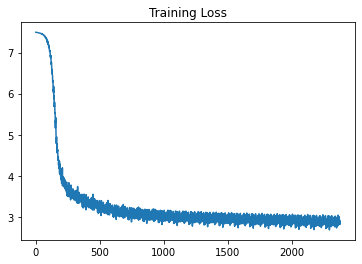

In [22]:
vocab_size = poetry_sy_lm_dataset.vocabulary.vocab_size + 2 # TODO: idk
batch_size = 450
embedding_size = 256  #power of 2 to exploit cache
len_input = 450
hidden_size = 256
n_epochs = 20
learning_rate = 1e-4

char_input = Input(shape=(batch_size,))
RNN = Sequential([
    Embedding(vocab_size, embedding_size,
              batch_input_shape=(batch_size, None)),
    
    LSTM(len_input, return_sequences = True),
    
    Dense(hidden_size, activation = relu), 
    
    Dense(vocab_size)
])
RNN.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate, clipvalue=0.5)

# This is an Autograph function
# its decorator makes it a TF op - i.e. much faster
@tf.function
def train_on_batch(x, y):
    with tf.GradientTape() as tape:
        cross_entropy = tf.keras.losses.sparse_categorical_crossentropy(y, RNN(x), from_logits = True)
        current_loss = tf.reduce_mean(cross_entropy)

    gradients = tape.gradient(current_loss, RNN.trainable_variables)
    optimizer.apply_gradients(zip(gradients, RNN.trainable_variables))
    return current_loss

loss_history = []

for epoch in range(n_epochs):
    start = time.time()
    print(epoch)
    
    for b in batches:
        x, y = b[0], b[1]
        x = np.asarray(x)
        y = np.asarray(y)
        x = np.expand_dims(x[:450], axis=1)
        y = np.expand_dims(y[:450], axis=1)
        
        current_loss = train_on_batch(x, y)
        loss_history.append(current_loss)
    
    print("{}.  \t  Loss: {}  \t  Time: {}ss".format(
        epoch+1, current_loss.numpy(), round(time.time()-start, 2)))


plt.plot(loss_history)
plt.title("Training Loss")
plt.show()

RNN.save("/lstm_dense.h5")

def generate_text(start_string, generator, num_generate = 1000, temperature = 1.0):
    input_eval = [char2idx[s] for s in start_string]  
    input_eval = tf.expand_dims(input_eval, 0)
    
    text_generated = []
    
    
    generator.reset_states()
    
    for i in range(num_generate):
        predictions = generator(input_eval)
        predictions = tf.squeeze(predictions, 0)
        
        # sample next char based on distribution and temperature
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])
        
    return (start_string + ''.join(text_generated))

init="""
Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura,
chè la diritta via era smarrita.
"""
print(generate_text(init))
